<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/SemiProject_HR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy            import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics  import confusion_matrix, accuracy_score, f1_score, roc_auc_score,\
                             precision_score,recall_score, roc_curve, classification_report,precision_recall_curve
from sklearn                 import preprocessing
# from sklearn.preprocessing   import StandardScaler,RobustScaler,MinMaxScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
import warnings
warnings.filterwarnings(action="ignore")
barline = "\n============================================"
e = "\n"

In [ ]:
df = pd.read_csv("train.csv")
df.shape

(54808, 14)

In [ ]:
# df.info()

In [ ]:
# df.head()

In [ ]:
# df.tail()

In [ ]:
# df["education"].value_counts() # 머신러닝으로 채워넣기(bike 참조)

In [ ]:
# df["recruitment_channel"].value_counts() #0~2 범주화 시키기 0:인력소싱업체 1:추천? 2:기타

In [ ]:
# df["department"].value_counts() #범주화 시키기 

In [ ]:
#df["region"].value_counts()  -> 나중에...

In [ ]:
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [ ]:
# import missingno as msno
# msno.bar(df)

In [ ]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


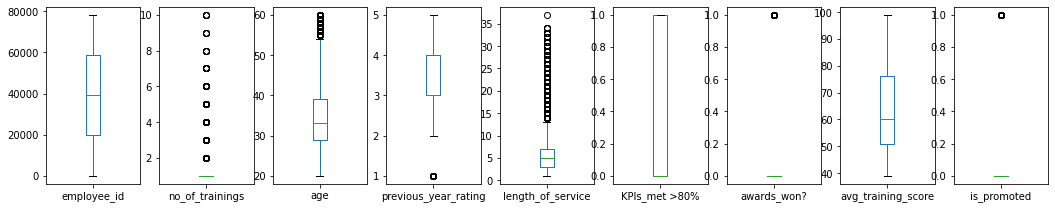

In [ ]:
df.plot(kind='box', subplots=True, figsize=(20, 15), layout=(4,10), sharex=False, sharey=False)
plt.show()

In [ ]:
df1 = df.drop("employee_id", axis=1)
# previous_year_rating: length_of_service가 1인 사람(새로운 직원)인 경우 전년도 평가 지표가 없음
df1["previous_year_rating"] = df1["previous_year_rating"].fillna(0)

# 나이: 20~60 구간? 5년..? 20~25, 26~30, 31~35, 36~40, 41~50, 50up
df1["age"].value_counts().sort_index()

def age_drop(age):
  if   age <= 25: cate = 0
  elif age <= 30: cate = 1
  elif age <= 35: cate = 2
  elif age <= 40: cate = 3
  elif age <= 50: cate = 4
  else:           cate = 5
  return cate

df1["age_cate"] = df1["age"].apply(lambda x: age_drop(x))

df1["age_cate"].value_counts()

# 지역 - region 34개


2    16065
1    15104
3     9963
4     7810
0     3014
5     2852
Name: age_cate, dtype: int64

In [ ]:
# length_of_service: 1, 2~4, 5~7, 8~10, 11~20, 21up
df1["length_of_service"].value_counts().sort_index()

def los_drop(year):
  if   year ==  1: cate = 0   # 신입
  elif year <=  4: cate = 1
  elif year <=  7: cate = 2
  elif year <= 10: cate = 3
  elif year <= 20: cate = 4
  else:            cate = 5   # 20년 넘게 근속
  return cate

df1["workyear"] = df1["length_of_service"].apply(lambda x: los_drop(x))

df1["workyear"].value_counts()

1    20553
2    16117
3     7705
4     5368
0     4547
5      518
Name: workyear, dtype: int64

In [ ]:
df1["gender"] = df1["gender"].apply(lambda x: 0 if x == "f" else 1)

df1["edu"]  = df1["education"].map({"Below Secondary": 0, "Bachelor's": 1, "Master's & above": 2})
df1["ch"]   = df1["recruitment_channel"].map({"other": 0, "sourcing": 1, "referred": 2})

df1.drop("education", axis=1, inplace=True)
df1.drop("recruitment_channel", axis=1, inplace=True)
df1.drop("age", axis=1, inplace=True)
df1.drop("length_of_service", axis=1, inplace=True)

df1.rename(columns={df1.columns[3]: 'train_no',
                    df1.columns[4]: 'last_rate',
                    df1.columns[5]: 'KPI80',
                    df1.columns[6]: 'awards',
                    df1.columns[7]: 'avg_score'}, inplace=True)


df1.head()

,department,region,gender,train_no,last_rate,KPI80,awards,avg_score,is_promoted,age_cate,workyear,edu,ch
0,Sales & Marketing,region_7,0,1,5.0,1,0,49,0,2,3,2.0,1
1,Operations,region_22,1,1,5.0,0,0,60,0,1,1,1.0,0
2,Sales & Marketing,region_19,1,1,3.0,0,0,50,0,2,2,1.0,1
3,Sales & Marketing,region_23,1,2,1.0,0,0,50,0,3,3,1.0,0
4,Technology,region_26,1,1,3.0,0,0,73,0,4,1,1.0,0


In [ ]:
df1.shape

(54808, 13)

In [ ]:
# rate_df = pd.DataFrame();
# rate_df["SER0"] = df["department"][df["is_promoted"]==0].value_counts()
# rate_df["SER1"] = df["department"][df["is_promoted"]==1].value_counts()
# rate_df["SER0_RATE"] = rate_df["SER0"]  / (rate_df["SER0"] + rate_df["SER1"])      # df["is_promoted"].count()
# rate_df["SER1_RATE"] = rate_df["SER1"]  / (rate_df["SER0"] + rate_df["SER1"]) * 100
# print(rate_df)

def rateCheck(df, col=""):
  rate_df = pd.DataFrame()
  rate_df["count0"] = df[col][df["is_promoted"]==0].value_counts()
  rate_df["count1"] = df[col][df["is_promoted"]==1].value_counts()
  rate_df["rate0"] = rate_df["count0"]  / (rate_df["count0"] + rate_df["count1"]) * 100     # df["is_promoted"].count()
  rate_df["rate1"] = rate_df["count1"]  / (rate_df["count0"] + rate_df["count1"]) * 100
  print(rate_df)

# rateCheck(df1, "region")

In [ ]:
#그래프
# plt.figure(figsize=(12,8))
# sns.countplot(df1['region'],hue=df1['is_promoted'],palette='Set1')
# plt.xticks(rotation=90)
# plt.show()

# df1["region"]
# df1["is_promoted"]

In [ ]:
# plt.figure(figsize=(12,8))
# sns.countplot(df1['avg_training_score'],hue=df1['is_promoted'],palette='pastel')
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
# plt.figure(figsize=(12,8))
# sns.countplot(df1['education'],hue=df1['is_promoted'],palette='Set3')
# plt.show()

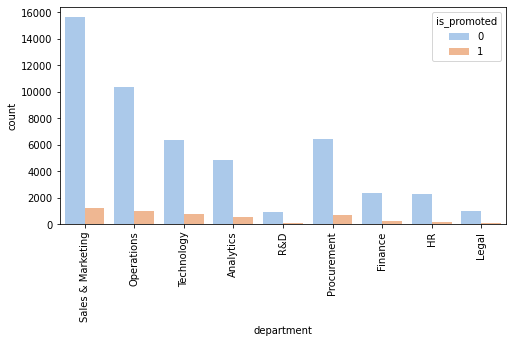

In [ ]:
plt.figure(figsize=(8, 4))
# sns.countplot(df1['gender'], hue=df1['is_promoted'],palette='pastel')
sns.countplot(df1['department'], hue=df1['is_promoted'],palette='pastel')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# plt.figure(figsize=(12,8))
# sns.countplot(df1['recruitment_channel'],hue=df1['is_promoted'],palette='YlOrRd_r')
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
df1["gender"].value_counts()

1    38496
0    16312
Name: gender, dtype: int64

In [ ]:
# Dataframe 확인 ---------------------------------------
def MyCheckDataframe(df, target="target") :
    print("Check Dataframe ----------------------------")
    print("Shape :", e, df.shape)
    print("Info  :", e, df.info())
    print("Head  :", e, df.head())
    print("Count :", e, df[target].value_counts())

    y = df[target]
    X = df.drop(target, axis=1)
    print("Target Shape :", e, X.shape, y.shape, barline)
    return X, y

In [ ]:
MyCheckDataframe(df1, "is_promoted")

Check Dataframe ----------------------------
Shape : 
 (54808, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   department   54808 non-null  object 
 1   region       54808 non-null  object 
 2   gender       54808 non-null  int64  
 3   train_no     54808 non-null  int64  
 4   last_rate    54808 non-null  float64
 5   KPI80        54808 non-null  int64  
 6   awards       54808 non-null  int64  
 7   avg_score    54808 non-null  int64  
 8   is_promoted  54808 non-null  int64  
 9   age_cate     54808 non-null  int64  
 10  workyear     54808 non-null  int64  
 11  edu          52399 non-null  float64
 12  ch           54808 non-null  int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 5.4+ MB
Info  : 
 None
Head  : 
           department     region  gender  train_no  ...  age_cate  workyear  edu  ch
0  Sales & Marketing   

(              department     region  gender  ...  workyear  edu  ch
 0      Sales & Marketing   region_7       0  ...         3  2.0   1
 1             Operations  region_22       1  ...         1  1.0   0
 2      Sales & Marketing  region_19       1  ...         2  1.0   1
 3      Sales & Marketing  region_23       1  ...         3  1.0   0
 4             Technology  region_26       1  ...         1  1.0   0
 ...                  ...        ...     ...  ...       ...  ...  ..
 54803         Technology  region_14       1  ...         4  1.0   1
 54804         Operations  region_27       0  ...         2  2.0   0
 54805          Analytics   region_1       1  ...         1  1.0   0
 54806  Sales & Marketing   region_9       1  ...         1  NaN   1
 54807                 HR  region_22       1  ...         2  1.0   0
 
 [54808 rows x 12 columns], 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 54803    0
 54804    0
 54805    0
 54806    0
 54807    0
 Name: is_p

In [ ]:
df1.info()
df1.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   department   54808 non-null  object 
 1   region       54808 non-null  object 
 2   gender       54808 non-null  int64  
 3   train_no     54808 non-null  int64  
 4   last_rate    54808 non-null  float64
 5   KPI80        54808 non-null  int64  
 6   awards       54808 non-null  int64  
 7   avg_score    54808 non-null  int64  
 8   is_promoted  54808 non-null  int64  
 9   age_cate     54808 non-null  int64  
 10  workyear     54808 non-null  int64  
 11  edu          52399 non-null  float64
 12  ch           54808 non-null  int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 5.4+ MB


(54808, 13)

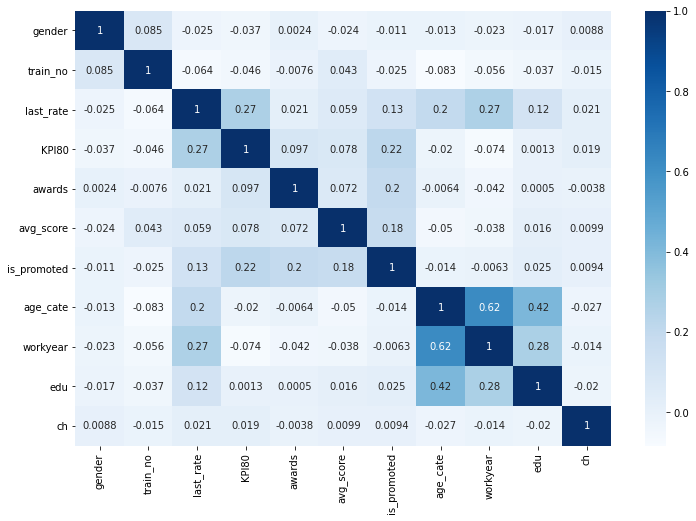

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df1.corr(), annot=True, fmt=".2g", cmap="Blues")

In [ ]:
df1

,department,region,gender,train_no,last_rate,KPI80,awards,avg_score,is_promoted,age_cate,workyear,edu,ch
0,Sales & Marketing,region_7,0,1,5.0,1,0,49,0,2,3,2.0,1
1,Operations,region_22,1,1,5.0,0,0,60,0,1,1,1.0,0
2,Sales & Marketing,region_19,1,1,3.0,0,0,50,0,2,2,1.0,1
3,Sales & Marketing,region_23,1,2,1.0,0,0,50,0,3,3,1.0,0
4,Technology,region_26,1,1,3.0,0,0,73,0,4,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,region_14,1,1,3.0,0,0,78,0,4,4,1.0,1
54804,Operations,region_27,0,1,2.0,0,0,56,0,3,2,2.0,0
54805,Analytics,region_1,1,1,5.0,1,0,79,0,1,1,1.0,0
54806,Sales & Marketing,region_9,1,1,1.0,0,0,45,0,1,1,NaN,1


In [ ]:
# department, region 수치형으로 변환 (one_hot encoding)
#df1["hot_dept"] = pd.get_dummies(data=df1, columns= ["department"])

In [ ]:
df1 = pd.get_dummies(data=df1, columns=["department"], prefix="dept_", drop_first = False)
df1 = pd.get_dummies(data=df1, columns=["region"], prefix="reg_", drop_first = False)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   54808 non-null  int64  
 1   train_no                 54808 non-null  int64  
 2   last_rate                54808 non-null  float64
 3   KPI80                    54808 non-null  int64  
 4   awards                   54808 non-null  int64  
 5   avg_score                54808 non-null  int64  
 6   is_promoted              54808 non-null  int64  
 7   age_cate                 54808 non-null  int64  
 8   workyear                 54808 non-null  int64  
 9   edu                      52399 non-null  float64
 10  ch                       54808 non-null  int64  
 11  dept__Analytics          54808 non-null  uint8  
 12  dept__Finance            54808 non-null  uint8  
 13  dept__HR                 54808 non-null  uint8  
 14  dept__Legal           

In [ ]:
df1.isnull().sum() # df1 의 결측치 확인 

gender                        0
train_no                      0
last_rate                     0
KPI80                         0
awards                        0
avg_score                     0
is_promoted                   0
age_cate                      0
workyear                      0
edu                        2409
ch                            0
dept__Analytics               0
dept__Finance                 0
dept__HR                      0
dept__Legal                   0
dept__Operations              0
dept__Procurement             0
dept__R&D                     0
dept__Sales & Marketing       0
dept__Technology              0
reg__region_1                 0
reg__region_10                0
reg__region_11                0
reg__region_12                0
reg__region_13                0
reg__region_14                0
reg__region_15                0
reg__region_16                0
reg__region_17                0
reg__region_18                0
reg__region_19                0
reg__reg

In [ ]:
# edu: null 채우기
edu_nan = df1[df1["edu"].isnull() == True]
edu_012 = df1[df1["edu"].isnull() == False]

col = df1.loc[:, df1.columns != 'edu'].columns

rf_edu = RandomForestRegressor()
rf_edu.fit(edu_012[col], edu_012["edu"])
edu_val = rf_edu.predict(X = edu_nan[col])
edu_nan["edu"] = edu_val
df1 = edu_012.append(edu_nan)

In [ ]:
# # null_edu_index = df1["edu"][df1["edu"].isnull].index
# # print(null_edu_index) # 이 부분은 일단 보류 - edu의 null 값은 내일 다시 체크 

# df1.drop("edu", axis=1,inplace=True) # edu의 null값 처리 (행인덱스 추출) 문법을 몰라서 일단 피처를 삭제했음.
# print(df1)

In [ ]:
# print(df1["edu"])
# print(df1["edu"].unique())

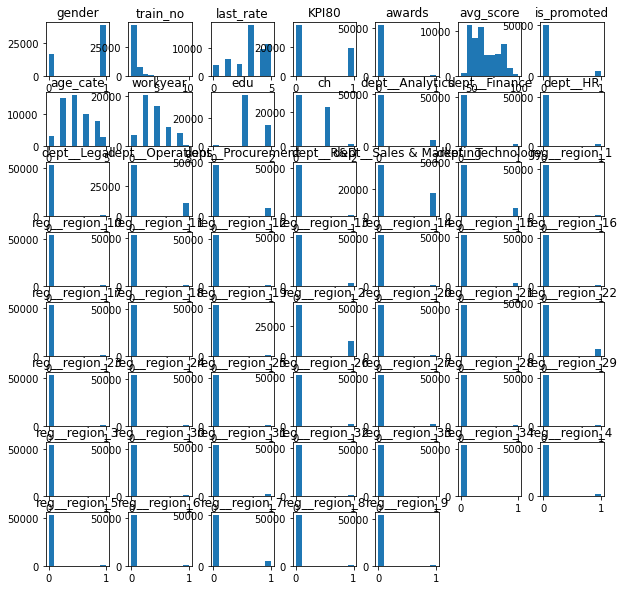

In [ ]:
# 히스토그램으로 데이터 분포 확인
df1.hist(bins=10, figsize=(10,10), grid=False)
plt.show()

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54808 entries, 0 to 54806
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   54808 non-null  int64  
 1   train_no                 54808 non-null  int64  
 2   last_rate                54808 non-null  float64
 3   KPI80                    54808 non-null  int64  
 4   awards                   54808 non-null  int64  
 5   avg_score                54808 non-null  int64  
 6   is_promoted              54808 non-null  int64  
 7   age_cate                 54808 non-null  int64  
 8   workyear                 54808 non-null  int64  
 9   edu                      54808 non-null  float64
 10  ch                       54808 non-null  int64  
 11  dept__Analytics          54808 non-null  uint8  
 12  dept__Finance            54808 non-null  uint8  
 13  dept__HR                 54808 non-null  uint8  
 14  dept__Legal           

In [ ]:
X = df1.drop("is_promoted", axis=1)
y = df1["is_promoted"]

In [ ]:
#모델 분석
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121, shuffle=True)
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)
str = "최초 점수"

print("------{}-------".format(str))
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
auc = roc_auc_score(y_test, proba[:,1].reshape(-1,1))

print("정확도{:.4f}  F1 {:.4f}=(정밀도{:.4f}  재현률{:.4f} auc{:.4f}) ".format(acc, f1, precision, recall, auc))
cf_matrix = confusion_matrix(y_test, pred)
print(cf_matrix)

ValueError: ignored

In [ ]:
# features = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# print(features)

In [ ]:
# top_5_features = features.keys()[:5]
# print(top_5_features)

In [ ]:
# #상위 5개 feature로 모델 재분석
# X_train, X_test, y_train, y_test = train_test_split(X[top_5_features], y, test_size=0.2, random_state=121, shuffle=True)
# model = RandomForestClassifier()
# model.fit(X_train, y_train)
# pred = model.predict(X_test)
# proba = model.predict_proba(X_test)
# str = "상위 5개 features 분석 결과"

# print("------{}-------".format(str))
# acc = accuracy_score(y_test, pred)
# f1 = f1_score(y_test, pred)
# precision = precision_score(y_test, pred)
# recall = recall_score(y_test, pred)
# auc = roc_auc_score(y_test, proba[:,1].reshape(-1,1))

# print("정확도{:.4f}  F1 {:.4f}=(정밀도{:.4f}  재현률{:.4f} auc{:.4f}) ".format(acc, f1, precision, recall, auc))
# cf_matrix = confusion_matrix(y_test, pred)
# print(cf_matrix)

In [ ]:
#Cross Validation
from sklearn.model_selection import cross_validate
my_score={"acc":"accuracy", "f1":"f1"} #scoring 여러개 주는 방법
score_list = cross_validate(model, X, y, scoring=my_score, cv=5, verbose=0)

In [ ]:
print("score_list----->", score_list)
score_df = pd.DataFrame(score_list)
print(score_df.head())
print("cross_validation 평균 정확도", score_df["test_acc"].mean())
print("cross_validation 평균 f1", score_df["test_f1"].mean())

score_list-----> {'fit_time': array([0.02735829, 0.02526093, 0.02537894, 0.02546144, 0.02515531]), 'score_time': array([0., 0., 0., 0., 0.]), 'test_acc': array([nan, nan, nan, nan, nan]), 'test_f1': array([nan, nan, nan, nan, nan])}
   fit_time  score_time  test_acc  test_f1
0  0.027358         0.0       NaN      NaN
1  0.025261         0.0       NaN      NaN
2  0.025379         0.0       NaN      NaN
3  0.025461         0.0       NaN      NaN
4  0.025155         0.0       NaN      NaN
cross_validation 평균 정확도 nan
cross_validation 평균 f1 nan


In [ ]:
my_hyper_param = { "n_estimators"      : [100, 300], # 랜덤 포레스트 안의 결정 트리 갯수 #default:100
                    "max_depth"        : [3,5,7,9], #최대 tree depth
                    "min_samples_leaf" : [1,3,5], #최소한으로 말단 노드 몇개 줄지 정함
                    "random_state"    :  [121,] #bootstrapping : 복원추출(나온번호 또 허용될 수 있음)
                } #randomforest의 parameter #랜덤포레스트가 가질 수 있는 파라미터를 여기에 지정해서 넣으면 됨


#GridSearchCV
from sklearn.model_selection import GridSearchCV
gcv_model = GridSearchCV(model, param_grid=my_hyper_param, scoring="accuracy", refit=True, cv=5, verbose=0) #refit=true: 가장 잘나온 최적의 모델을 찾아냈으면 바로 예측에 반영시켜라  #cv : 몇번 돌릴건지 #f1이 scoring해주므로 밑에 score해줄 필요 x
#제일 좋은 모델 찾아서 학습 시키고 출력해라
#predict도 필요 없음. 내부적으로 파라미터을 준 갯수만큼 가장 좋았던 모델을 여기에 던져주므로

gcv_model.fit(X_train, y_train)
print("best_estimator_", gcv_model.best_estimator_) #제일 좋은 모델
print("best_params_",     gcv_model.best_params_) #제일 좋았던 파라미터
print("best_score_",     gcv_model.best_score_) #제일 잘나온 점수
y_pred = model.predict(X_test).astype(np.int32)

KeyboardInterrupt: ignored

In [ ]:
def SPLIT_FIT_PREDICT(model, X, y, str=None, rate=0.2, prc=False, roc=False) :
    X_train ,X_test , y_train, y_test = train_test_split(X, y, test_size=rate, random_state=121)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
    SCORES(y_test, pred, proba, str)

    if prc == True: #일반적으로 그리지 말고 true면 그려라
        CHART_PRECISION_RECALL_CURV(y_test, proba)
    if roc == True:
        CHART_ROC_CURV(y_test, proba, auc)
    return X_train, X_test, y_train, y_test 

def SCORES(y_test, pred, proba, str=None) :
    print("------{}-------".format(str))
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #auc = roc_auc_score(y_test, pred)
    auc = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
    print("정확도{:.4f}  F1 {:.4f}=(정밀도{:.4f}  재현률{:.4f} auc{:.4f}) ".format(acc, f1, precision, recall, auc))
    cf_matrix = confusion_matrix(y_test, pred)
    print(cf_matrix)

In [ ]:
print(df1.shape)
print(df1["is_promoted"].value_counts())
P_df = df1[df1["is_promoted"] == 1]
N_df = df1[df1["is_promoted"] == 0][:len(P_df)] #positive df만큼 가져오기
under_df = P_df.append(N_df)
print(P_df.shape, N_df.shape, under_df.shape)

y = under_df["is_promoted"]
X = under_df.drop("is_promoted", axis=1)
model = RandomForestClassifier()
print(X.shape, y.shape)

SPLIT_FIT_PREDICT(model, X, y, str="undersampling 점수", rate=0.2) #점수 올리려면 standardscaling 하면됨

(54808, 54)
0    50140
1     4668
Name: is_promoted, dtype: int64
(4668, 54) (4668, 54) (9336, 54)
(9336, 53) (9336,)
------undersampling 점수-------
정확도0.8116  F1 0.8220=(정밀도0.7750  재현률0.8751 auc0.8959) 
[[703 236]
 [116 813]]


(       gender  train_no  last_rate  ...  reg__region_7  reg__region_8  reg__region_9
 34739       1         1        5.0  ...              0              0              0
 4707        1         2        5.0  ...              1              0              0
 24309       1         1        3.0  ...              0              0              0
 34106       1         1        3.0  ...              0              0              0
 1685        1         1        4.0  ...              0              0              0
 ...       ...       ...        ...  ...            ...            ...            ...
 4475        0         1        3.0  ...              0              0              0
 1325        1         1        5.0  ...              0              0              0
 26199       0         1        4.0  ...              0              0              0
 3199        0         1        1.0  ...              0              0              0
 3851        1         1        3.0  ...              

In [ ]:
from imblearn.over_sampling import SMOTE

print(df1.shape)
print(df1["is_promoted"].value_counts())

y = df1["is_promoted"] #undersampling 영향 안받게 다시 읽어와서 X,y 끊어줌
X = df1.drop("is_promoted", axis=1)
smote = SMOTE()
X_over, y_over = smote.fit_resample(X, y)

print(X_over.shape, y_over.shape)
print(pd.Series(y_over).value_counts()) #array이므로 세로형으로 바꾸기 위해서 reshape

model = RandomForestClassifier()
print(X.shape, y.shape)
SPLIT_FIT_PREDICT(model, X_over, y_over, str="oversampling 점수", rate=0.2)

(54808, 54)
0    50140
1     4668
Name: is_promoted, dtype: int64
(100280, 53) (100280,)
1    50140
0    50140
dtype: int64
(54808, 53) (54808,)
------oversampling 점수-------
정확도0.9641  F1 0.9631=(정밀도0.9791  재현률0.9477 auc0.9932) 
[[9935  201]
 [ 519 9401]]


(array([[0.        , 1.        , 5.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 1.        , 3.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 1.        , 5.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 1.        , 3.        , ..., 0.30158552, 0.        ,
         0.        ],
        [0.        , 1.        , 5.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 2.        , 4.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([[1.        , 1.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.62555124, 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0. 

In [ ]:
def MySplitFitPredict(model, X, y, str=None, rate=0.2, prc=False, roc=False) :
    X_train ,X_test , y_train, y_test = train_test_split(X, y, test_size=rate, random_state=121)
    model.fit(X_train, y_train)
    pred  = model.predict(X_test)
    proba = model.predict_proba(X_test)

    MyScores(y_test, pred, proba, str)

    if prc == True:
        MyChartPrcRclCurve(y_test, proba)
    if roc == True:
        MyChartRocCurve(y_test, proba)
    return proba # X_train, X_test, y_train, y_test, proba # , pred, proba

In [ ]:
def MyScores(y_test, pred, proba, str=None) :
    print("Scores : {} ---------" .format(str))
    acc       = accuracy_score(y_test, pred)
    f1        = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall    = recall_score(y_test, pred)
    auc       = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
    print("정확도{:.4f}  F1 {:.4f}=(정밀도{:.4f} 재현률{:.4f}) auc {:.4f}" .format(acc, f1, precision, recall, auc))
    cf_matrix = confusion_matrix(y_test, pred)
    print("Confusion Matrix", e, cf_matrix, barline)

In [ ]:
MyCheckDataframe(df1, target="is_promoted")

In [ ]:
model = RandomForestClassifier()
MySplitFitPredict(model, X, y)
# model = RandomForestClassifier()
# model.fit(X_train, y_train)
# pred  = model.predict(X_test)
# proba = model.predict_proba(X_test)

# MyScores(y_test, pred, proba, str)